### Explainability API ## 

## Imports

In [28]:
import sys
import itertools
import random
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

sys.path.append('../..')

from gemini.utils import *
from drift_detector.explainer import Explainer
from baseline_models.static.utils import run_model

## Get data

In [26]:
SHIFT = input("Select experiment: ")  
HOSPITALS = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW", "PMH","SBK"]
OUTCOME = "mortality"
PATH = "/mnt/nfs/project/delirium/drift_exp/JULY-04-2022/"
MODEL_PATH = os.path.join(PATH,"saved_models",SHIFT+"_lstm.pt")
TIMESTEPS = 6
AGGREGATION_TYPE = "time_flatten"
THRESHOLD=0.05
NUM_TIMESTEPS = 6

random.seed(1)

admin_data, x, y = get_gemini_data(PATH)

(X_tr, y_tr), (X_val, y_val), (X_t, y_t), feats, admin_data = import_dataset_hospital(admin_data, x, y, SHIFT, OUTCOME, HOSPITALS)

# Normalize data
X_tr_normalized  = normalize(admin_data, X_tr, AGGREGATION_TYPE, TIMESTEPS)
X_val_normalized = normalize(admin_data, X_val, AGGREGATION_TYPE, TIMESTEPS)
X_t_normalized = normalize(admin_data, X_t, AGGREGATION_TYPE, TIMESTEPS)
    
if AGGREGATION_TYPE != "time":
    # Get labels
    y_tr = get_label(admin_data, X_tr, OUTCOME)
    y_val = get_label(admin_data, X_val, OUTCOME)
    y_t = get_label(admin_data, X_t, OUTCOME)
    
# Scale data
X_tr_scaled = scale(X_tr_normalized)
X_val_scaled = scale(X_val_normalized)
X_t_scaled = scale(X_t_normalized)

# Process data
X_tr_final = process(X_tr_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_val_final = process(X_val_scaled, AGGREGATION_TYPE, TIMESTEPS)
X_t_final = process(X_t_scaled, AGGREGATION_TYPE, TIMESTEPS)

Select experiment:  hosp_type_community


2022-10-11 21:29:45,939 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggregated_events.parquet


Load data from aggregated events...


2022-10-11 21:29:46,450 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_start_ts.parquet
2022-10-11 21:29:46,644 INFO cyclops.feature_handler - Loading features from file...
2022-10-11 21:29:46,648 INFO cyclops.feature_handler - Found file to load for static features...
2022-10-11 21:29:46,652 INFO cyclops.feature_handler - Successfully loaded static features from file...
2022-10-11 21:29:46,690 INFO cyclops.feature_handler - Found file to load for temporal features...


Load data from feature handler...


2022-10-11 21:29:51,801 INFO cyclops.feature_handler - Successfully loaded temporal features from file...


Load data from admin data...


2022-10-11 21:30:01,072 INFO cyclops.utils.file - Loading dataframe to /mnt/nfs/project/delirium/drift_exp/JULY-04-2022/aggmeta_end_ts.parquet


## Get model

In [29]:
MODEL_NAME = input("Select Model: ")
MODEL_PATH = PATH + "_".join([SHIFT, OUTCOME, '_'.join(HOSPITALS), MODEL_NAME]) + ".pkl"
if os.path.exists(MODEL_PATH):
    optimised_model = pickle.load(open(MODEL_PATH, "rb"))
else:
    optimised_model = run_model(MODEL_NAME, X_tr_final, y_tr, X_val_final, y_val)
    pickle.dump(optimised_model, open(MODEL_PATH, 'wb'))

Select Model:  xgb


Best g: 0.5
Best n: 3


## Explain difference in model predictions ## 

In [31]:
explainer = Explainer(optimised_model, X_tr_final)
explainer.get_explainer()

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


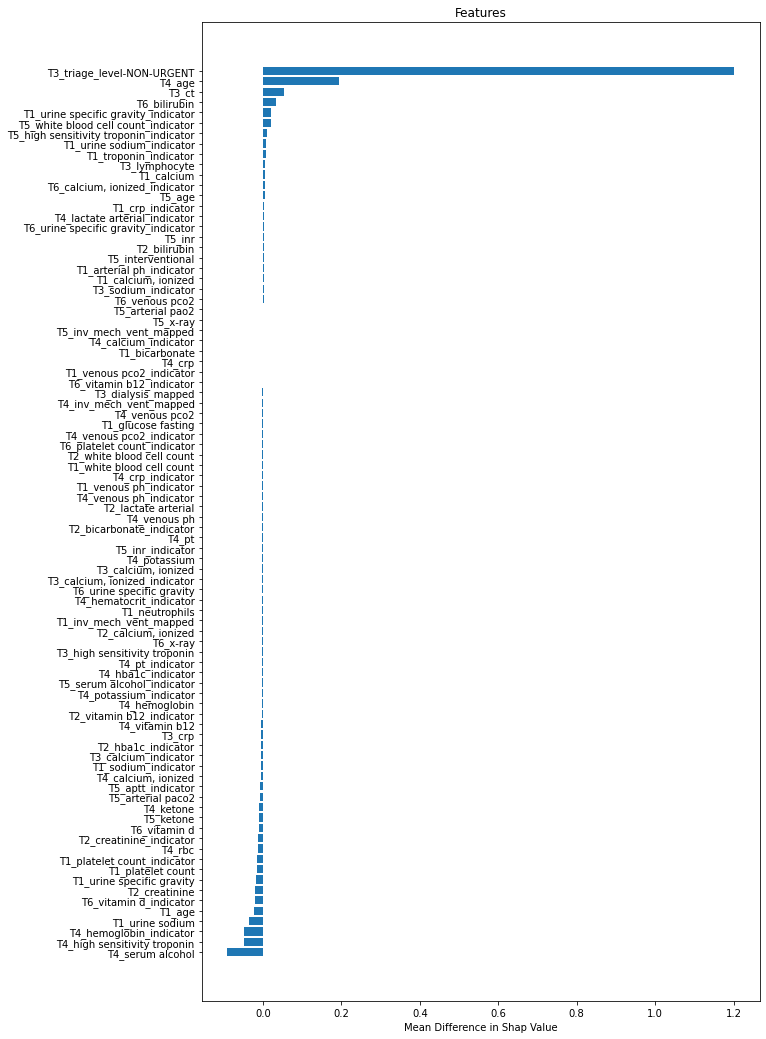

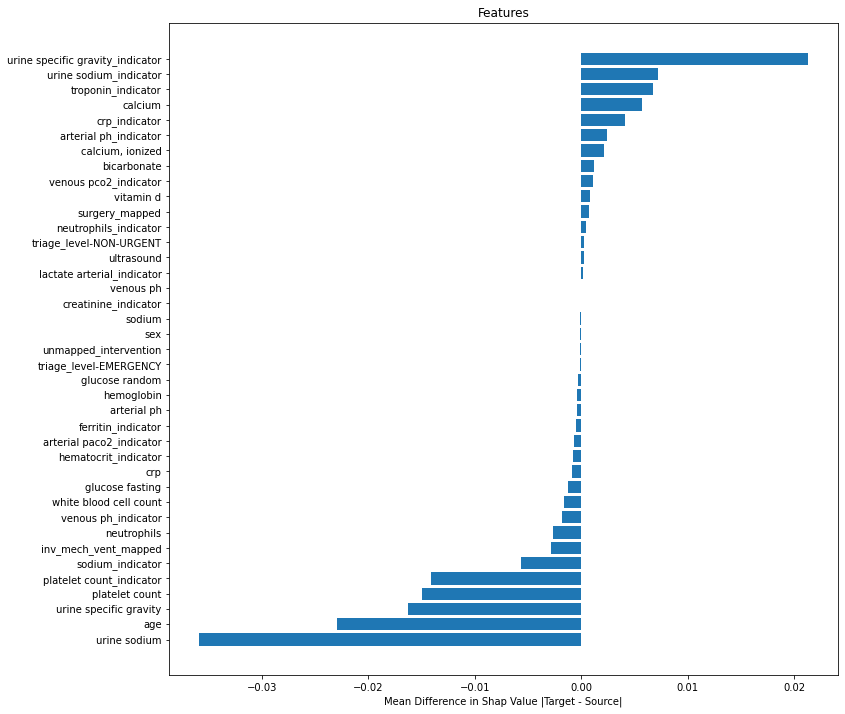

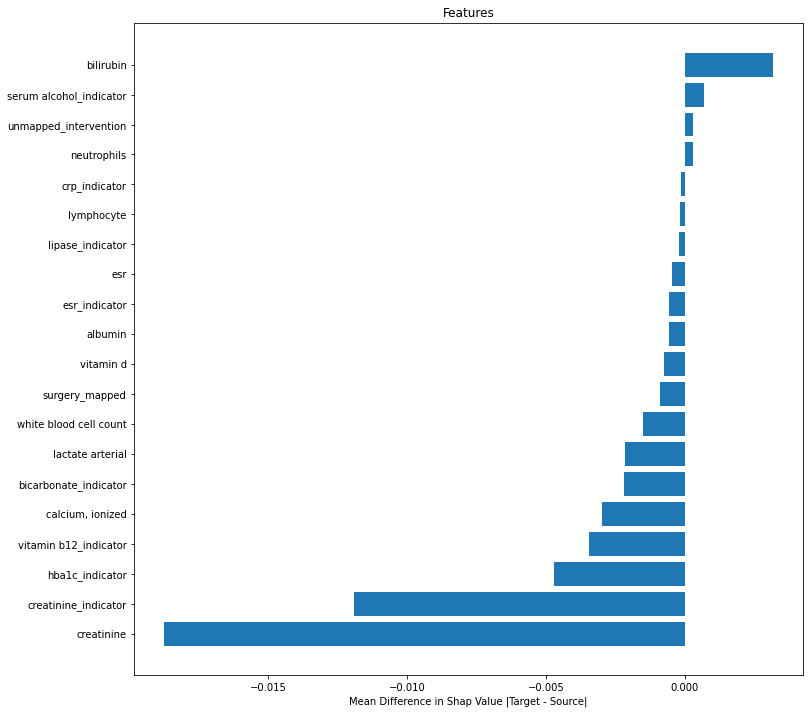

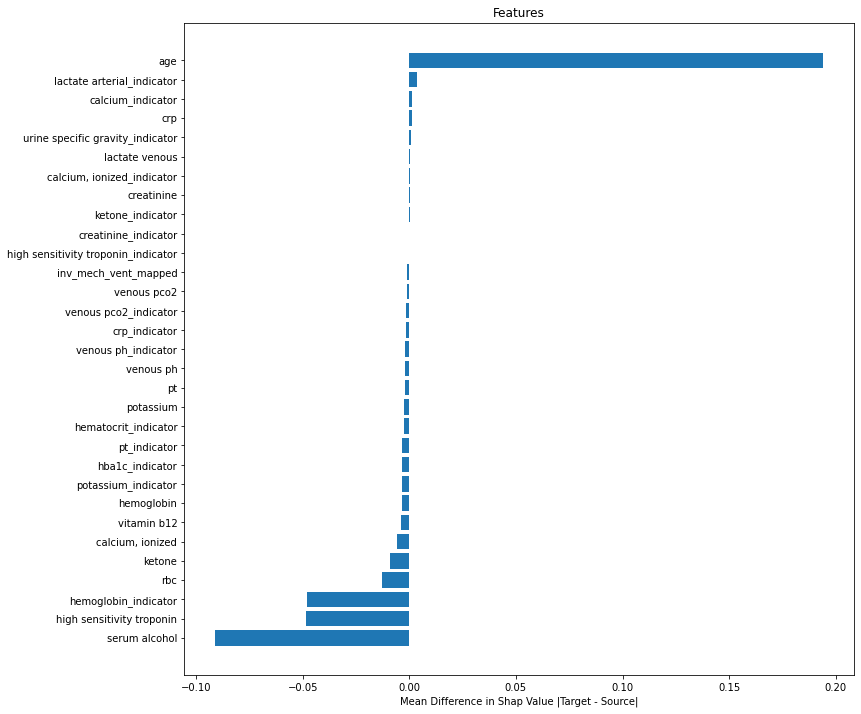

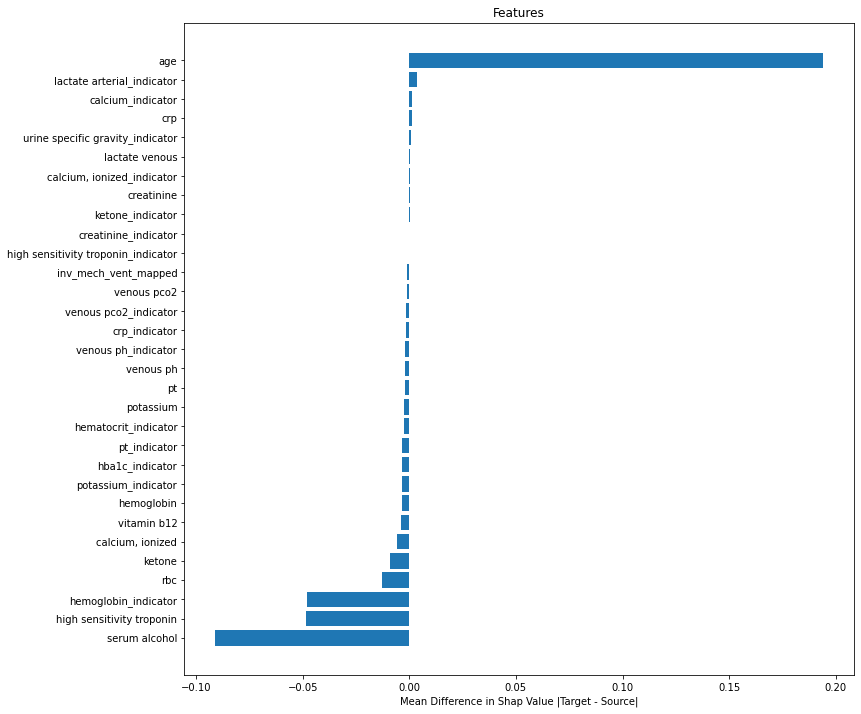

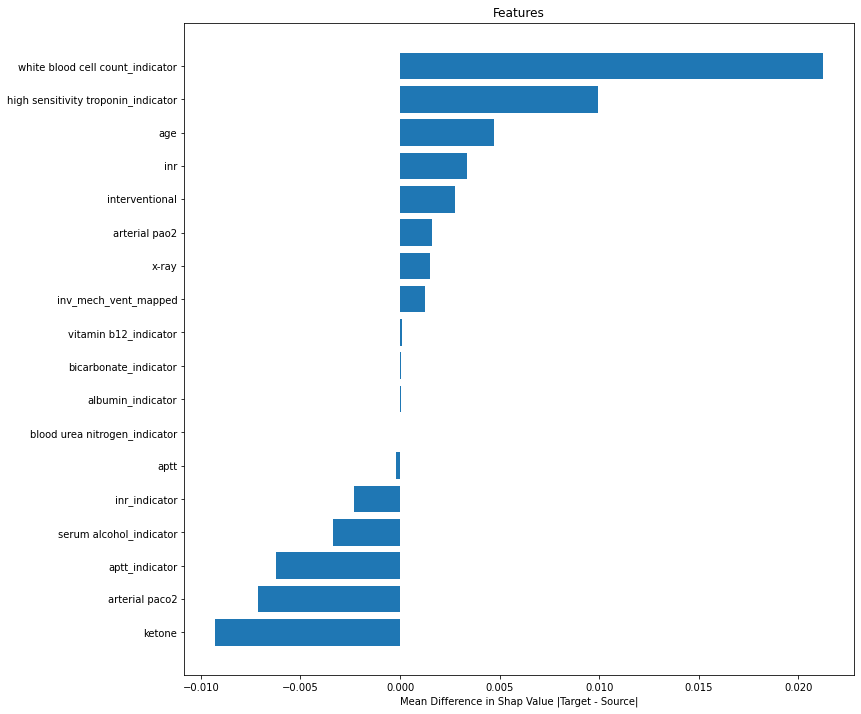

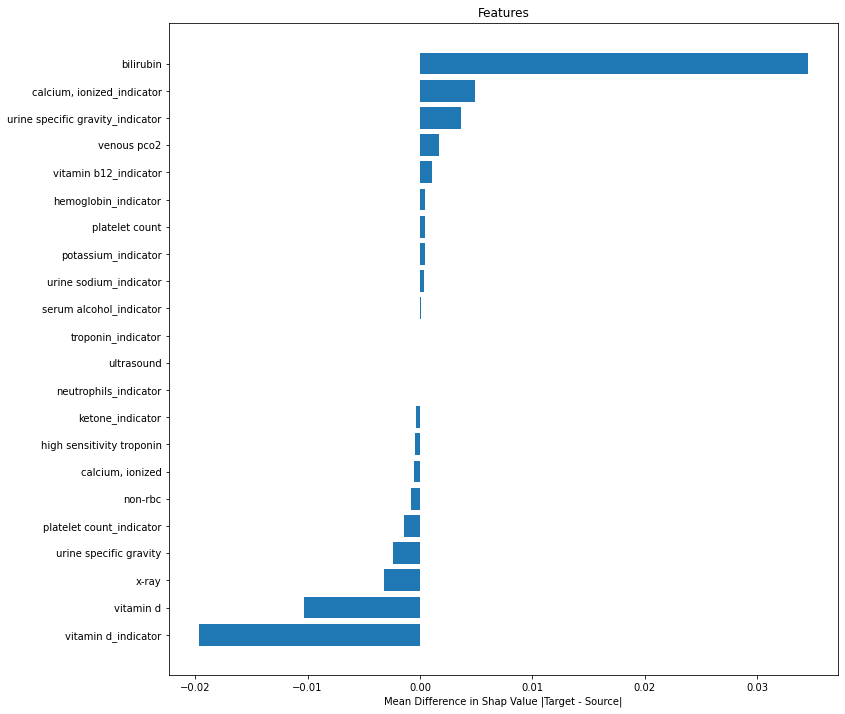

In [91]:
timesteps = ['T1_', 'T2_','T3_','T4_', 'T5_','T6_']

flattened_feats = []
for ts in timesteps:
    flattened_feats.append(ts+feats)
flattened_feats = list(itertools.chain.from_iterable(flattened_feats))

X_val_df = pd.DataFrame(X_val_final, columns=flattened_feats)
val_shap_values = explainer.get_shap_values(X_val_df)
X_test_df = pd.DataFrame(X_t_final, columns=flattened_feats)
test_shap_values = explainer.get_shap_values(X_test_df)

shap_diff = np.mean(np.abs(test_shap_values.values), axis=0) - np.mean(
    np.abs(val_shap_values.values), axis=0
)
shap_min = -0.001
shap_max = 0.001
shap_diff_sorted, feats_sorted = zip(*sorted(zip(shap_diff, flattened_feats), reverse=True))
shap_diff_sorted, feats_sorted = zip(
    *(((x, y) for x, y in zip(shap_diff_sorted, feats_sorted) if (x > shap_max or x < shap_min)))
)

shap_feats = {
    'feature': feats_sorted,
    'shap_diff': list(shap_diff_sorted)
}
    
fig, ax = plt.subplots(figsize=(10, 18))
y_pos = np.arange(len(shap_feats['shap_diff']))
ax.barh(y_pos, shap_feats['shap_diff'], align="center")
ax.set_yticks(y_pos, labels=shap_feats['feature'])
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Mean Difference in Shap Value")
ax.set_title("Features")
plt.show()

shap_diff_sorted, feats_sorted = zip(*sorted(zip(shap_diff, flattened_feats), reverse=True))
shap_diff_sorted, feats_sorted = zip(
    *(((x, y) for x, y in zip(shap_diff_sorted, feats_sorted) if (x != 0)))
)

for t in ['T1_','T2_','T4_','T4_','T5_','T6_']:
    shap_feats = {
        'feature': feats_sorted,
        'shap_diff': list(shap_diff_sorted)
    }
    shap_feats = {k: [x for i, x in enumerate(v) if any(ts in shap_feats['feature'][i] for ts in [t])] for k, v in shap_feats.items()}
    shap_feats['feature']=list(map(lambda x: x.replace(t, ''),shap_feats['feature']))
    fig, ax = plt.subplots(figsize=(12, 12))
    y_pos = np.arange(len(shap_feats['shap_diff']))
    ax.barh(y_pos, shap_feats['shap_diff'], align="center")
    ax.set_yticks(y_pos, labels=shap_feats['feature'])
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel("Mean Difference in Shap Value |Target - Source|")
    ax.set_title("Features")
    plt.show()